# 94812 - A3 Applications of NL(X) and LLMS 

## Individual Assigment

Name: Abdul Rehman

Andrew ID: marehman

Date Created: Feb 14 2024

##### Objective:
To build a stock price prediction model incorporating both historical data and social media sentiment, evaluate its accuracy on the GameStop short squeeze, and analyze potential improvements based on the event.

The timeframe we'll focus on is between DEC 2020 to MAR 2021

### 0. Import Relevant Packages

In [206]:
import datetime
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.tag import pos_tag
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.sentiment import SentimentIntensityAnalyzer
import numpy as np
import pandas as pd
from pandas_datareader import data as pdr
import plotly.graph_objects as go
import praw
from praw.models import MoreComments
import re
import yfinance as yfin
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense


yfin.pdr_override()
pd.set_option('display.max_rows', None)

In [61]:
start_date = '2020-10-01'
end_date = '2021-03-31'

### 1. Model Building

#### A) Import the Necessary Data

##### i. Stock Data

The data that we're looking for in this section include stock prices and trading volume

In [62]:
gme = pdr.get_data_yahoo('GME', start=start_date, end=end_date)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/yfinance/utils.py:775: FutureWarning:

The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.

[*********************100%%**********************]  1 of 1 completed


In [63]:
gme.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-10-01,2.5225,2.5625,2.4225,2.4425,2.4425,18216400
2020-10-02,2.3450,2.4450,2.3250,2.3475,2.3475,17362000
2020-10-05,2.3600,2.3975,2.3125,2.3650,2.3650,11220000
2020-10-06,2.3900,2.4600,2.2750,2.2825,2.2825,18141600
2020-10-07,2.3075,2.3900,2.2925,2.3400,2.3400,13234400


We will only keep the closing price and the volume:

In [64]:
gme = gme.reset_index()
desired_columns = ['Date', 'Close', 'Volume']

gme = gme.loc[:, desired_columns]
gme.head()

,Date,Close,Volume
0,2020-10-01,2.4425,18216400
1,2020-10-02,2.3475,17362000
2,2020-10-05,2.3650,11220000
3,2020-10-06,2.2825,18141600
4,2020-10-07,2.3400,13234400


Lets see how the price and trading volume varied throughout the year:

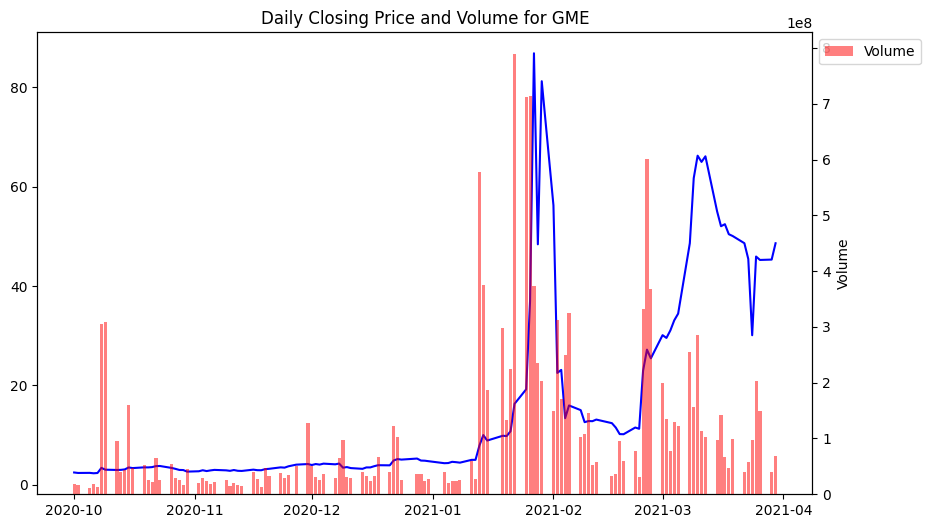

In [65]:
# Plot Closing Price
plt.figure(figsize=(10, 6))
plt.plot(gme['Date'], gme['Close'], color='blue', label='Closing Price')

# Create a secondary y-axis for Volume
plt.twinx()
plt.bar(gme['Date'], gme['Volume'], color='red', alpha=0.5, label='Volume')

# Set labels and title
plt.title("Daily Closing Price and Volume for GME")
plt.xlabel("Date")
plt.ylabel("Price")
plt.gca().set_ylabel("Volume")  # Set y-axis label for the right side
plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))

plt.show()

It looks like most of the trading happened in January and February 2021

##### ii. Twitter + Reddit Data

First we'll extract data from Reddit (specifically from r/wallstreetbets):

In [66]:
reddit = praw.Reddit(client_id="tuNEgsXUD-QNygNmvpcoNw",         # your client id
                               client_secret="CDI5XPnP0n4Lzs300aMOGB8GNGKGfw",      # your client secret
                               user_agent="nlx_scraping")        # your user agent

In [67]:
subreddit = reddit.subreddit("wallstreetbets")
query = r'\bGameStop\b'


In [68]:
# Convert start date string to a datetime object
start_date = datetime.datetime.strptime(start_date, '%Y-%m-%d')
# Convert end date string to a datetime object
end_date = datetime.datetime.strptime(end_date, '%Y-%m-%d')

In [69]:
# Initialize lists to store data
data = []

# Convert dates to Unix timestamps
start_timestamp = int(start_date.timestamp())
end_timestamp = int(end_date.timestamp())

search_results = subreddit.search(query, sort='new', time_filter='all', limit=None)

# Process search results and filter by date range
for submission in search_results:
    # Check if the submission timestamp is within the specified date range
    submission_timestamp = submission.created_utc

    if start_timestamp <= submission_timestamp <= end_timestamp:
        # Get N top-level comments from the submission
        submission.comment_sort = 'top'
        submission.comment_limit = 50
        for comment in submission.comments:
            if isinstance(comment, MoreComments):
                continue
            # Filter comments with scores greater than 20
            if comment.score > 20:
                # Append comment data to the list
                data.append({
                    'Submission Title': submission.title,
                    'Submission Text': submission.selftext,
                    'Submission ID': submission.id,
                    'Submission Score': submission.score,
                    'Submission Total Comments': submission.num_comments,
                    'Submission URL': submission.url,
                    'Submission Date Posted': datetime.datetime.utcfromtimestamp(submission_timestamp).strftime('%Y-%m-%d %H:%M:%S'),
                    'Comment Body': comment.body,
                    'Comment ID': comment.id,
                    'Comment Score': comment.score,
                    'Comment Author': comment.author.name if comment.author else None,
                    'Comment Date Posted': datetime.datetime.utcfromtimestamp(comment.created_utc).strftime('%Y-%m-%d %H:%M:%S')
                })


reddit_data_df = pd.DataFrame(data)

In [70]:
reddit_data_df = reddit_data_df.sort_values(by='Comment Date Posted')
reddit_data_df.head(13)

,Submission Title,Submission Text,Submission ID,Submission Score,Submission Total Comments,Submission URL,Submission Date Posted,Comment Body,Comment ID,Comment Score,Comment Author,Comment Date Posted
461,GME - MST Announcement may trigger Short Squeeze,In case you haven't seen the news - [https://t...,j7imj4,193,250,https://www.reddit.com/r/wallstreetbets/commen...,2020-10-08 18:32:50,"I sold the 20k worth of calls yesterday, fuk m...",g84uti2,107,vinosama,2020-10-08 18:38:51
466,GME - MST Announcement may trigger Short Squeeze,In case you haven't seen the news - [https://t...,j7imj4,193,250,https://www.reddit.com/r/wallstreetbets/commen...,2020-10-08 18:32:50,What is this “partnership” in concrete terms? ...,g84vtek,29,Prodigal_Moon,2020-10-08 18:45:22
460,GME - MST Announcement may trigger Short Squeeze,In case you haven't seen the news - [https://t...,j7imj4,193,250,https://www.reddit.com/r/wallstreetbets/commen...,2020-10-08 18:32:50,I honestly don't feel sorry for the tards who ...,g84w5gd,127,MusicalxFelony,2020-10-08 18:47:34
462,GME - MST Announcement may trigger Short Squeeze,In case you haven't seen the news - [https://t...,j7imj4,193,250,https://www.reddit.com/r/wallstreetbets/commen...,2020-10-08 18:32:50,"50,000,000 shorts still need to cover this wil...",g84wpkz,66,PhatCalls,2020-10-08 18:51:13
464,GME - MST Announcement may trigger Short Squeeze,In case you haven't seen the news - [https://t...,j7imj4,193,250,https://www.reddit.com/r/wallstreetbets/commen...,2020-10-08 18:32:50,"Paging u/DeepFuckingValue, just bought a new b...",g84zhxd,31,dstaxx,2020-10-08 19:10:03
467,GME - MST Announcement may trigger Short Squeeze,In case you haven't seen the news - [https://t...,j7imj4,193,250,https://www.reddit.com/r/wallstreetbets/commen...,2020-10-08 18:32:50,There’s a guy in here that was holding 400k wo...,g851ikw,23,stepheaw,2020-10-08 19:23:56
465,GME - MST Announcement may trigger Short Squeeze,In case you haven't seen the news - [https://t...,j7imj4,193,250,https://www.reddit.com/r/wallstreetbets/commen...,2020-10-08 18:32:50,So many margin calls going out tonight,g851t76,32,Stonksflyingup,2020-10-08 19:26:06
463,GME - MST Announcement may trigger Short Squeeze,In case you haven't seen the news - [https://t...,j7imj4,193,250,https://www.reddit.com/r/wallstreetbets/commen...,2020-10-08 18:32:50,I fucking sold a $10 strike covered call on 8k...,g8587pm,35,Beastmode3792,2020-10-08 20:12:50
444,The REAL Greatest Short Burn of the Century Pa...,>[Oh and uh short burn of the century comin so...,k4csaa,2624,918,https://www.reddit.com/r/wallstreetbets/commen...,2020-12-01 03:38:42,Did anyone read this? I didn't.\n\nI just saw ...,ge84nfg,86,iobviouslyamme,2020-12-01 03:51:01
436,The REAL Greatest Short Burn of the Century Pa...,>[Oh and uh short burn of the century comin so...,k4csaa,2624,918,https://www.reddit.com/r/wallstreetbets/commen...,2020-12-01 03:38:42,Say less I just bought every share on the market,ge84pxr,261,hugh_g_reckshon,2020-12-01 03:51:40


In [71]:
reddit_data_df.shape

(468, 12)

#### B) Feature Engineering

##### i. Stock Data

We'll create some additional features that we can use to feed into our prediction model:

In [72]:
# Create a copy of the original DataFrame
gme_extended_df = gme.copy()

# Feature 1: Lag features for closing price (1 day lag)
gme_extended_df['Close_Lag1'] = gme_extended_df['Close'].shift(1)

# Feature 2: Rolling statistics for closing price (7-day moving average)
gme_extended_df['Close_Mean_7d'] = gme_extended_df['Close'].rolling(window=7).mean()

# Feature 3: Rolling statistics for closing price (30-day moving average)
gme_extended_df['Close_Mean_30d'] = gme_extended_df['Close'].rolling(window=30).mean()

# Feature 4: Rolling statistics for volume (7-day moving average)
gme_extended_df['Volume_Mean_7d'] = gme_extended_df['Volume'].rolling(window=7).mean()

# Feature 5: Rolling statistics for volume (30-day moving average)
gme_extended_df['Volume_Mean_30d'] = gme_extended_df['Volume'].rolling(window=30).mean()


Lets make sure we have data for the days and months we're predicting:

In [73]:
gme_extended_df.head(40)

,Date,Close,Volume,Close_Lag1,Close_Mean_7d,Close_Mean_30d,Volume_Mean_7d,Volume_Mean_30d
0,2020-10-01,2.4425,18216400,NaN,NaN,NaN,NaN,NaN
1,2020-10-02,2.3475,17362000,2.4425,NaN,NaN,NaN,NaN
2,2020-10-05,2.3650,11220000,2.3475,NaN,NaN,NaN,NaN
3,2020-10-06,2.2825,18141600,2.3650,NaN,NaN,NaN,NaN
4,2020-10-07,2.3400,13234400,2.2825,NaN,NaN,NaN,NaN
5,2020-10-08,3.3725,305814400,2.3400,NaN,NaN,NaN,NaN
6,2020-10-09,3.0050,308611200,3.3725,2.593571,NaN,9.894286e+07,NaN
7,2020-10-12,2.9500,94622800,3.0050,2.666071,NaN,1.098581e+08,NaN
8,2020-10-13,2.9700,40718800,2.9500,2.755000,NaN,1.131947e+08,NaN
9,2020-10-14,3.0625,43045600,2.9700,2.854643,NaN,1.177413e+08,NaN


##### ii. Reddit Data:

We need to do a significant amount of feature engineering for the reddit data:

In [74]:
# Define the clean_text function
def clean_text(text):
    # Convert text to lowercase
    text = text.lower()
    # Remove special characters, punctuation, and numbers
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Tokenize the text
    tokens = word_tokenize(text)
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    filtered_tokens = [word for word in tokens if word not in stop_words]
    # Join tokens back into a single string
    cleaned_text = ' '.join(filtered_tokens)
    return cleaned_text

In [75]:
# Apply the clean_text function to the 'Comment Body' column
reddit_data_df['Cleaned Text'] = reddit_data_df['Comment Body'].apply(clean_text)

In [76]:
reddit_data_df.head(10)['Cleaned Text'].iloc[9]

'say less bought every share market'

Now lets tokenize and pos tag the text:

In [77]:
# Tokenize function
def tokenize_text(text):
    tokens = word_tokenize(text)
    return tokens

# Part-of-speech tagging function
def pos_tag_text(tokens):
    pos_tags = pos_tag(tokens)
    return pos_tags

In [78]:
# Tokenize each text in the DataFrame and store the results in a new column
reddit_data_df['Tokenized'] = reddit_data_df['Cleaned Text'].apply(tokenize_text)

# Perform part-of-speech tagging on each tokenized text and store the results in another column
reddit_data_df['POS_Tagged'] = reddit_data_df['Tokenized'].apply(pos_tag_text)

In [79]:
reddit_data_df.head(10)

,Submission Title,Submission Text,Submission ID,Submission Score,Submission Total Comments,Submission URL,Submission Date Posted,Comment Body,Comment ID,Comment Score,Comment Author,Comment Date Posted,Cleaned Text,Tokenized,POS_Tagged
461,GME - MST Announcement may trigger Short Squeeze,In case you haven't seen the news - [https://t...,j7imj4,193,250,https://www.reddit.com/r/wallstreetbets/commen...,2020-10-08 18:32:50,"I sold the 20k worth of calls yesterday, fuk m...",g84uti2,107,vinosama,2020-10-08 18:38:51,sold k worth calls yesterday fuk life,"[sold, k, worth, calls, yesterday, fuk, life]","[(sold, VBN), (k, JJ), (worth, JJ), (calls, NN..."
466,GME - MST Announcement may trigger Short Squeeze,In case you haven't seen the news - [https://t...,j7imj4,193,250,https://www.reddit.com/r/wallstreetbets/commen...,2020-10-08 18:32:50,What is this “partnership” in concrete terms? ...,g84vtek,29,Prodigal_Moon,2020-10-08 18:45:22,partnership concrete terms pr sounds like gme ...,"[partnership, concrete, terms, pr, sounds, lik...","[(partnership, NN), (concrete, NN), (terms, NN..."
460,GME - MST Announcement may trigger Short Squeeze,In case you haven't seen the news - [https://t...,j7imj4,193,250,https://www.reddit.com/r/wallstreetbets/commen...,2020-10-08 18:32:50,I honestly don't feel sorry for the tards who ...,g84w5gd,127,MusicalxFelony,2020-10-08 18:47:34,honestly dont feel sorry tards opportunity jum...,"[honestly, dont, feel, sorry, tards, opportuni...","[(honestly, RB), (dont, JJ), (feel, NN), (sorr..."
462,GME - MST Announcement may trigger Short Squeeze,In case you haven't seen the news - [https://t...,j7imj4,193,250,https://www.reddit.com/r/wallstreetbets/commen...,2020-10-08 18:32:50,"50,000,000 shorts still need to cover this wil...",g84wpkz,66,PhatCalls,2020-10-08 18:51:13,shorts still need cover rip,"[shorts, still, need, cover, rip]","[(shorts, NNS), (still, RB), (need, VBP), (cov..."
464,GME - MST Announcement may trigger Short Squeeze,In case you haven't seen the news - [https://t...,j7imj4,193,250,https://www.reddit.com/r/wallstreetbets/commen...,2020-10-08 18:32:50,"Paging u/DeepFuckingValue, just bought a new b...",g84zhxd,31,dstaxx,2020-10-08 19:10:03,paging udeepfuckingvalue bought new bottle lot...,"[paging, udeepfuckingvalue, bought, new, bottl...","[(paging, VBG), (udeepfuckingvalue, JJ), (boug..."
467,GME - MST Announcement may trigger Short Squeeze,In case you haven't seen the news - [https://t...,j7imj4,193,250,https://www.reddit.com/r/wallstreetbets/commen...,2020-10-08 18:32:50,There’s a guy in here that was holding 400k wo...,g851ikw,23,stepheaw,2020-10-08 19:23:56,theres guy holding k worth gme,"[theres, guy, holding, k, worth, gme]","[(theres, NNS), (guy, VBP), (holding, VBG), (k..."
465,GME - MST Announcement may trigger Short Squeeze,In case you haven't seen the news - [https://t...,j7imj4,193,250,https://www.reddit.com/r/wallstreetbets/commen...,2020-10-08 18:32:50,So many margin calls going out tonight,g851t76,32,Stonksflyingup,2020-10-08 19:26:06,many margin calls going tonight,"[many, margin, calls, going, tonight]","[(many, JJ), (margin, NN), (calls, VBZ), (goin..."
463,GME - MST Announcement may trigger Short Squeeze,In case you haven't seen the news - [https://t...,j7imj4,193,250,https://www.reddit.com/r/wallstreetbets/commen...,2020-10-08 18:32:50,I fucking sold a $10 strike covered call on 8k...,g8587pm,35,Beastmode3792,2020-10-08 20:12:50,fucking sold strike covered call k shares like...,"[fucking, sold, strike, covered, call, k, shar...","[(fucking, VBG), (sold, VBN), (strike, NN), (c..."
444,The REAL Greatest Short Burn of the Century Pa...,>[Oh and uh short burn of the century comin so...,k4csaa,2624,918,https://www.reddit.com/r/wallstreetbets/commen...,2020-12-01 03:38:42,Did anyone read this? I didn't.\n\nI just saw ...,ge84nfg,86,iobviouslyamme,2020-12-01 03:51:01,anyone read didnt saw gme upvoted,"[anyone, read, didnt, saw, gme, upvoted]","[(anyone, NN), (read, VBD), (didnt, NN), 

Now we are ready to build our models.

#### C) Model Building

We will train an LSTM to make our stock predictions for the months of December 2020, January 2021, and February 2021:

In [37]:
# Drop rows with NaN values resulting from feature engineering
gme_extended_df.dropna(inplace=True)

# Define features and target variable
features = ['Close_Lag1', 'Close_Mean_7d', 'Close_Mean_30d', 'Volume_Mean_7d', 'Volume_Mean_30d']
target = 'Close'

# Split data into features (X) and target variable (y)
X = gme_extended_df[features]
y = gme_extended_df[target]

Earlier we specified a start date for when we want to be gathering data but now we will specify a start date for predictions

In [85]:
start_date = pd.to_datetime('2020-12-01')
end_date = pd.to_datetime('2021-02-28')
start_date = pd.to_datetime(start_date)
end_date = pd.to_datetime(end_date)

##### Model 1A: Lets train an LSTM Model

In [172]:
# Perform iterative training and prediction
predictions = []

filtered_df = gme_extended_df[(gme_extended_df['Date'] >= start_date) & (gme_extended_df['Date'] <= end_date)]

for i in range(filtered_df.shape[0]):
    # Extract data up to current date for training
    train_data = gme_extended_df[(gme_extended_df['Date'] >= gme_extended_df['Date'].iloc[29]) 
                                 & (gme_extended_df['Date'] <= gme_extended_df['Date'].iloc[41+i])]
    train = train_data.drop(columns=['Date'])
    # Drop the last row from X_train and store it in X_test
    X_test = train.iloc[-1]
    X_train = train.drop(train.index[-1])
    y_train = train_data['Close']
    y_train = y_train.drop(y_train.index[0])
    X_train, y_train = np.array(X_train), np.array(y_train)

    # Initialize the LSTM model
    model = Sequential([
        LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)),  # Use X_train shape as input shape
        Dropout(0.2),
        LSTM(units=50, return_sequences=True),
        Dropout(0.2),
        LSTM(units=50),
        Dropout(0.2),
        Dense(units=1)
    ])
    # Compile the model
    model.compile(optimizer='adam', loss='mean_squared_error')
    
    model.fit(X_train, y_train, epochs=1, batch_size=32, verbose=0)
    
    # Reshape X_test
    X_test = X_test.values.reshape(1, X_train.shape[1], 1)

    prediction = model.predict(X_test)
    predictions.append(prediction[0][0])


1/1 [==============================] - 1s 601ms/step


Let's plot the prediction:

(60,)


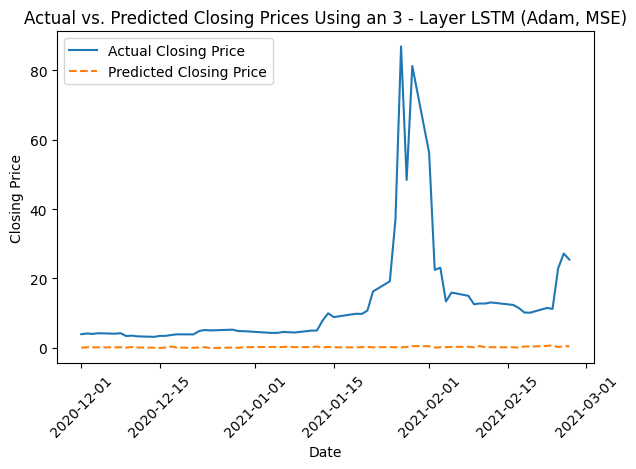

In [174]:
# Filter gme_extended_df based on start_date and end_date
filtered_df = gme_extended_df[(gme_extended_df['Date'] >= start_date) & (gme_extended_df['Date'] <= end_date)]

# Extract dates and actual closing prices for plotting
dates = filtered_df['Date']
actual_closing_prices = filtered_df['Close']

print(actual_closing_prices.shape)
# Plot actual closing prices
plt.plot(dates, actual_closing_prices, label='Actual Closing Price')

# Plot predicted closing prices
plt.plot(dates, predictions, label='Predicted Closing Price', linestyle='--')

# Set labels and title
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.title('Actual vs. Predicted Closing Prices Using an 3 - Layer LSTM (Adam, MSE)')
plt.legend()

# Rotate x-axis labels for better visibility
plt.xticks(rotation=45)

# Show plot
plt.tight_layout()
plt.show()

Lets calculate some metrics to gauge the accuracy of our model:

In [182]:
# Define model details
model_name = 'LSTM 3-layer'
optimizer = 'adam'
loss_function = 'mean_squared_error'

# Calculate MSE, RMSE, and MAE
mse = ((actual_closing_prices - predictions) ** 2).mean()
rmse = mse ** 0.5
mae = (actual_closing_prices - predictions).abs().mean()

# Combine model details into a single string
model_details = f"{model_name}, Optimizer: {optimizer}, Loss Function: {loss_function}"

# Create a DataFrame with the metrics and model details
metrics_df = pd.DataFrame({
    'Model Name': [model_details],
    'MSE': [mse],
    'RMSE': [rmse],
    'MAE': [mae]
})

metrics_df.head()

,Model Name,MSE,RMSE,MAE
0,"LSTM 3-layer, Optimizer: adam, Loss Function: ...",454.991444,21.330528,13.259205


Lets attempt to create a grid search to look through the best number of layers, optmizer type, and the best loss function to use:

Training model: LSTM 1-layer, Optimizer: adam, Loss Function: mean_squared_error
1/1 [==============================] - 0s 425ms/step


/var/folders/vx/8dby43hn17xcd7y9qn2k2kjc0000gn/T/ipykernel_30688/2984917947.py:67: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



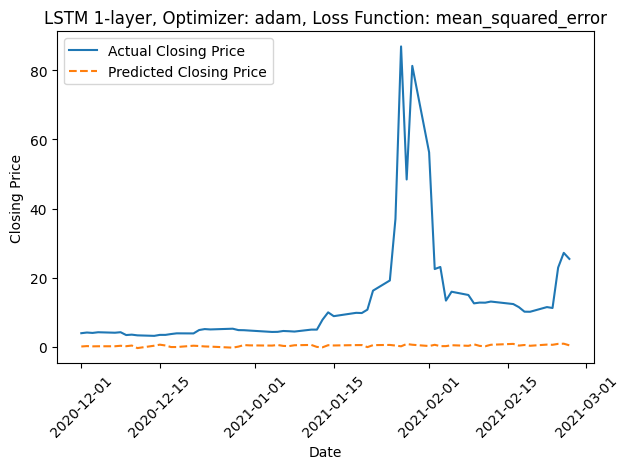

Training model: LSTM 1-layer, Optimizer: adam, Loss Function: mean_absolute_error
1/1 [==============================] - 0s 498ms/step


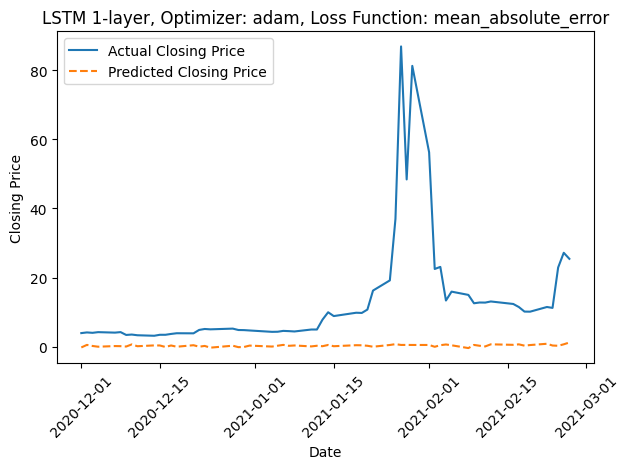

Training model: LSTM 1-layer, Optimizer: rmsprop, Loss Function: mean_squared_error
1/1 [==============================] - 1s 828ms/step


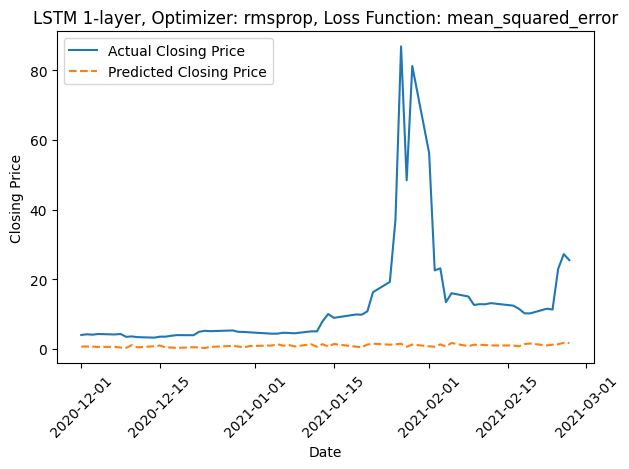

Training model: LSTM 1-layer, Optimizer: rmsprop, Loss Function: mean_absolute_error
1/1 [==============================] - 1s 610ms/step


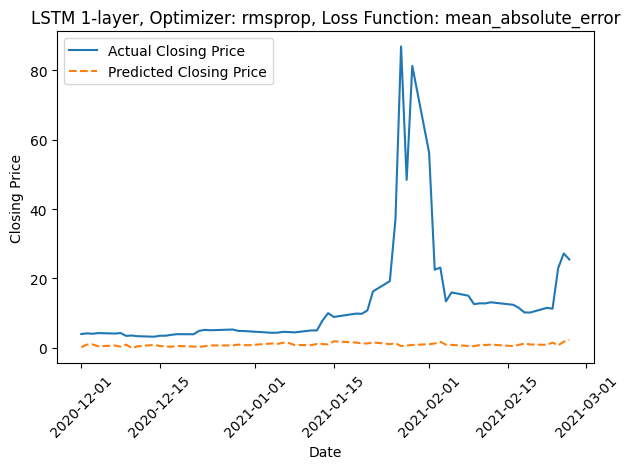

Training model: LSTM 2-layer, Optimizer: adam, Loss Function: mean_squared_error
1/1 [==============================] - 3s 3s/step


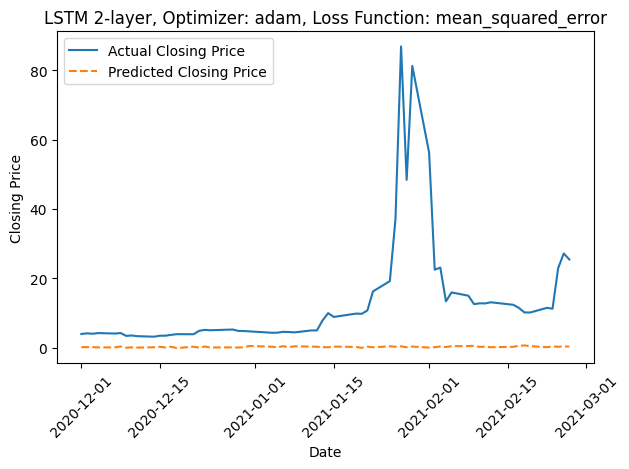

Training model: LSTM 2-layer, Optimizer: adam, Loss Function: mean_absolute_error
1/1 [==============================] - 2s 2s/step


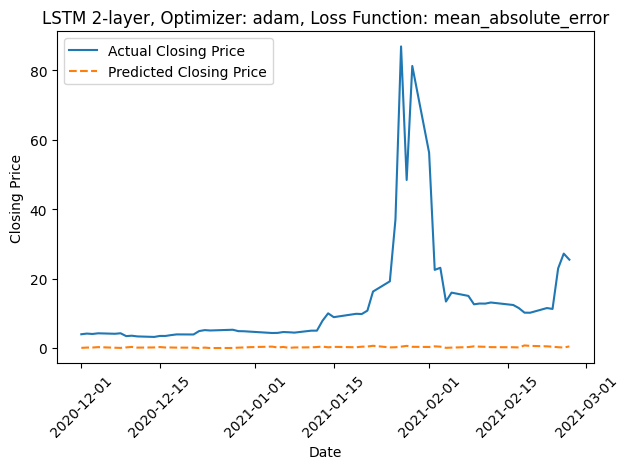

Training model: LSTM 2-layer, Optimizer: rmsprop, Loss Function: mean_squared_error
1/1 [==============================] - 3s 3s/step


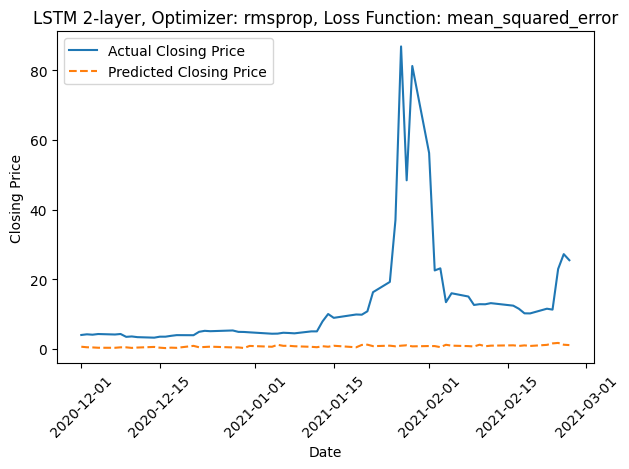

Training model: LSTM 2-layer, Optimizer: rmsprop, Loss Function: mean_absolute_error
1/1 [==============================] - 2s 2s/step


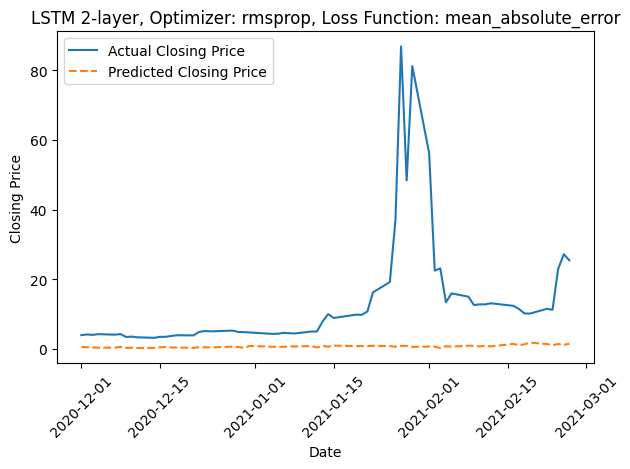

Training model: LSTM 3-layer, Optimizer: adam, Loss Function: mean_squared_error
1/1 [==============================] - 3s 3s/step


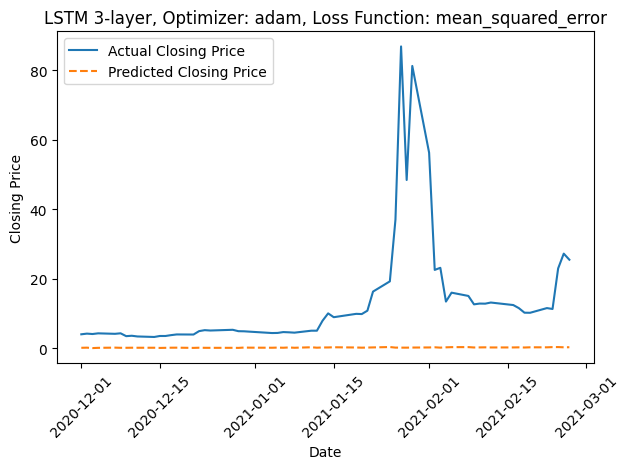

Training model: LSTM 3-layer, Optimizer: adam, Loss Function: mean_absolute_error
1/1 [==============================] - 8s 8s/step


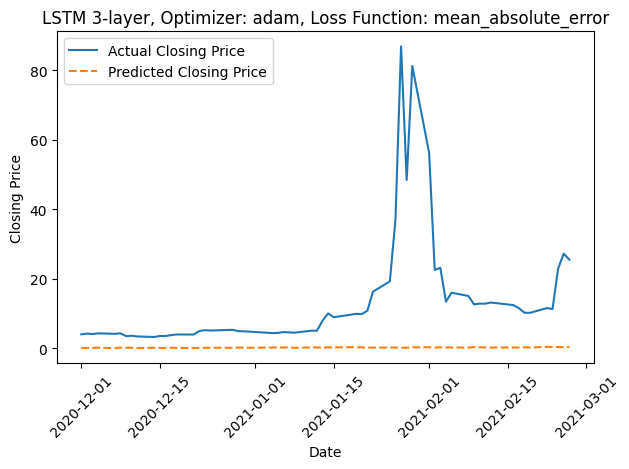

Training model: LSTM 3-layer, Optimizer: rmsprop, Loss Function: mean_squared_error
1/1 [==============================] - 8s 8s/step


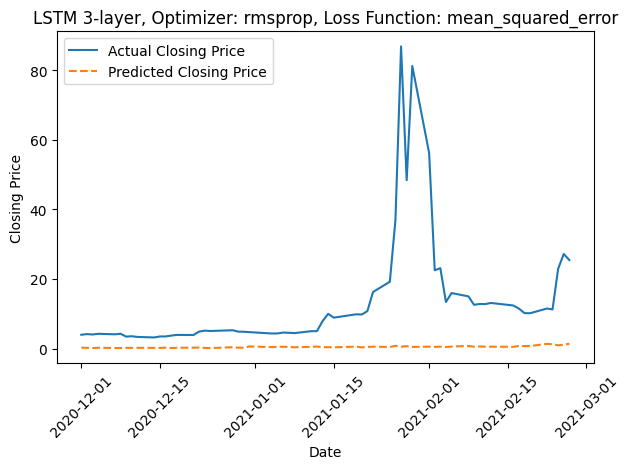

Training model: LSTM 3-layer, Optimizer: rmsprop, Loss Function: mean_absolute_error
1/1 [==============================] - 7s 7s/step


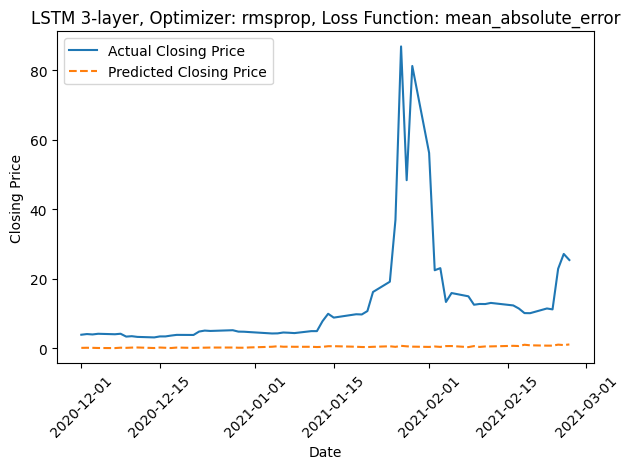

                                           Model Name         MSE       RMSE  \
0   LSTM 1-layer, Optimizer: adam, Loss Function: ...  451.363735  21.245323   
1   LSTM 1-layer, Optimizer: adam, Loss Function: ...  450.872634  21.233762   
2   LSTM 1-layer, Optimizer: rmsprop, Loss Functio...  435.530850  20.869376   
3   LSTM 1-layer, Optimizer: rmsprop, Loss Functio...  438.038911  20.929379   
4   LSTM 2-layer, Optimizer: adam, Loss Function: ...  455.335497  21.338592   
5   LSTM 2-layer, Optimizer: adam, Loss Function: ...  454.333615  21.315103   
6   LSTM 2-layer, Optimizer: rmsprop, Loss Functio...  441.170030  21.004048   
7   LSTM 2-layer, Optimizer: rmsprop, Loss Functio...  441.709394  21.016884   
8   LSTM 3-layer, Optimizer: adam, Loss Function: ...  458.593994  21.414808   
9   LSTM 3-layer, Optimizer: adam, Loss Function: ...  458.302686  21.408005   
10  LSTM 3-layer, Optimizer: rmsprop, Loss Functio...  447.309158  21.149685   
11  LSTM 3-layer, Optimizer: rmsprop, Lo

In [199]:
# Filter gme_extended_df based on start_date and end_date
filtered_df = gme_extended_df[(gme_extended_df['Date'] >= start_date) & (gme_extended_df['Date'] <= end_date)]

# Define grid search parameters
num_layers = [1, 2, 3]
optimizers = ['adam', 'rmsprop']
loss_functions = ['mean_squared_error', 'mean_absolute_error']

# Initialize DataFrame to store metrics
metrics_df = pd.DataFrame(columns=['Model Name', 'MSE', 'RMSE', 'MAE'])

# Perform grid search
for num_layer in num_layers:
    for optimizer in optimizers:
        for loss_function in loss_functions:
            # Construct model name
            model_name = f"LSTM {num_layer}-layer, Optimizer: {optimizer}, Loss Function: {loss_function}"
            print(f"Training model: {model_name}")

            # Perform iterative training and prediction
            predictions = []

            for i in range(filtered_df.shape[0]):
                # Extract data up to current date for training
                train_data = gme_extended_df[(gme_extended_df['Date'] >= gme_extended_df['Date'].iloc[29]) 
                                            & (gme_extended_df['Date'] <= gme_extended_df['Date'].iloc[41+i])]
                train = train_data.drop(columns=['Date'])
                # Drop the last row from X_train and store it in X_test
                X_test = train.iloc[-1]
                X_train = train.drop(train.index[-1])
                y_train = train_data['Close']
                y_train = y_train.drop(y_train.index[0])
                X_train, y_train = np.array(X_train), np.array(y_train)

                # Initialize model
                model = Sequential()
                model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))  # Use X_train shape as input shape
                model.add(Dropout(0.2))
                for _ in range(num_layer-1):
                    model.add(LSTM(units=50, return_sequences=True))
                    model.add(Dropout(0.2))
                model.add(LSTM(units=50))
                model.add(Dropout(0.2))
                model.add(Dense(units=1))

                # Compile model
                model.compile(optimizer=optimizer, loss=loss_function)

                model.fit(X_train, y_train, epochs=1, batch_size=32, verbose=0)

                # Reshape X_test
                X_test_reshaped = X_test.values.reshape(1, X_train.shape[1], 1)

                prediction = model.predict(X_test_reshaped)
                predictions.append(prediction[0][0])

            # Extract dates and actual closing prices for calculating metrics
            dates = filtered_df['Date']
            actual_closing_prices = filtered_df['Close'].values  # Convert to 1D array

            # Calculate metrics
            mse = ((actual_closing_prices - predictions) ** 2).mean()
            rmse = mse ** 0.5
            mae = (actual_closing_prices - predictions).mean()

            # Append metrics to DataFrame
            metrics_df = pd.concat([metrics_df, pd.DataFrame({
                'Model Name': [model_name],
                'MSE': [mse],
                'RMSE': [rmse],
                'MAE': [mae]
            })], ignore_index=True)

            # Plot predicted vs actual closing prices
            plt.plot(dates, actual_closing_prices, label='Actual Closing Price')
            plt.plot(dates, predictions, label='Predicted Closing Price', linestyle='--')
            plt.xlabel('Date')
            plt.ylabel('Closing Price')
            plt.title(model_name)
            plt.xticks(rotation=45)
            plt.legend()
            plt.tight_layout()
            plt.show()

print(metrics_df)

##### ii. Sentiment Analysis

Now we will conduct sentiment analysis on the reddit data:

In [208]:
# Initialize the SentimentIntensityAnalyzer
sid = SentimentIntensityAnalyzer()

# Function to calculate compound sentiment score
def calculate_sentiment_score(text):
    # Calculate sentiment scores
    scores = sid.polarity_scores(text)
    # Return the compound score
    return scores['compound']

# Example usage:
# Assuming 'text' is the column containing the text data
# and 'df' is your DataFrame

# Apply the function to each row in the 'text' column
reddit_data_df['compound_score'] = reddit_data_df['Cleaned Text'].apply(calculate_sentiment_score)

# Display the DataFrame with the compound sentiment scores
reddit_data_df.head()

,Submission Title,Submission Text,Submission ID,Submission Score,Submission Total Comments,Submission URL,Submission Date Posted,Comment Body,Comment ID,Comment Score,Comment Author,Comment Date Posted,Cleaned Text,Tokenized,POS_Tagged,compound_score
461,GME - MST Announcement may trigger Short Squeeze,In case you haven't seen the news - [https://t...,j7imj4,193,250,https://www.reddit.com/r/wallstreetbets/commen...,2020-10-08 18:32:50,"I sold the 20k worth of calls yesterday, fuk m...",g84uti2,107,vinosama,2020-10-08 18:38:51,sold k worth calls yesterday fuk life,"[sold, k, worth, calls, yesterday, fuk, life]","[(sold, VBN), (k, JJ), (worth, JJ), (calls, NN...",0.2263
466,GME - MST Announcement may trigger Short Squeeze,In case you haven't seen the news - [https://t...,j7imj4,193,250,https://www.reddit.com/r/wallstreetbets/commen...,2020-10-08 18:32:50,What is this “partnership” in concrete terms? ...,g84vtek,29,Prodigal_Moon,2020-10-08 18:45:22,partnership concrete terms pr sounds like gme ...,"[partnership, concrete, terms, pr, sounds, lik...","[(partnership, NN), (concrete, NN), (terms, NN...",0.3612
460,GME - MST Announcement may trigger Short Squeeze,In case you haven't seen the news - [https://t...,j7imj4,193,250,https://www.reddit.com/r/wallstreetbets/commen...,2020-10-08 18:32:50,I honestly don't feel sorry for the tards who ...,g84w5gd,127,MusicalxFelony,2020-10-08 18:47:34,honestly dont feel sorry tards opportunity jum...,"[honestly, dont, feel, sorry, tards, opportuni...","[(honestly, RB), (dont, JJ), (feel, NN), (sorr...",0.7388
462,GME - MST Announcement may trigger Short Squeeze,In case you haven't seen the news - [https://t...,j7imj4,193,250,https://www.reddit.com/r/wallstreetbets/commen...,2020-10-08 18:32:50,"50,000,000 shorts still need to cover this wil...",g84wpkz,66,PhatCalls,2020-10-08 18:51:13,shorts still need cover rip,"[shorts, still, need, cover, rip]","[(shorts, NNS), (still, RB), (need, VBP), (cov...",0.0000
464,GME - MST Announcement may trigger Short Squeeze,In case you haven't seen the news - [https://t...,j7imj4,193,250,https://www.reddit.com/r/wallstreetbets/commen...,2020-10-08 18:32:50,"Paging u/DeepFuckingValue, just bought a new b...",g84zhxd,31,dstaxx,2020-10-08 19:10:03,paging udeepfuckingvalue bought new bottle lot...,"[paging, udeepfuckingvalue, bought, new, bottl...","[(paging, VBG), (udeepfuckingvalue, JJ), (boug...",0.0000


In [217]:
# Create a new DataFrame with selected columns
sub_df = reddit_data_df.loc[:, ['Comment Date Posted', 'Comment Body', 'compound_score']]

for i in range(10):
    print(i)
    print(sub_df.iloc[i]['Comment Body'])
    print(sub_df.iloc[i]['compound_score'])

0
I sold the 20k worth of calls yesterday, fuk my life
0.2263
1
What is this “partnership” in concrete terms? The PR sounds like GME is just using MS cloud for backend stuff and maybe some tablets with customer profiles or something.
0.3612
2
I honestly don't feel sorry for the tards who had the opportunity to jump in on this despite the shit ton of DDs and other b.s. get fucked bears. The parties just getting started.
0.7388
3
50,000,000 shorts still need to cover this will rip
0.0
4
Paging u/DeepFuckingValue, just bought a new bottle of lotion and I'm still gonna chafe
0.0
5
There’s a guy in here that was holding 400k worth of gme where he at
0.2263
6
So many margin calls going out tonight
0.0
7
I fucking sold a $10 strike covered call on 8k shares when it was at like 9.25 and am missing this whole run FUCK
-0.4173
8
Did anyone read this? I didn't.

I just saw $GME and I upvoted.
0.0
9
Say less I just bought every share on the market
0.235


Let's create some visualizations for the sentiment analysis:

In [220]:
import seaborn as sns

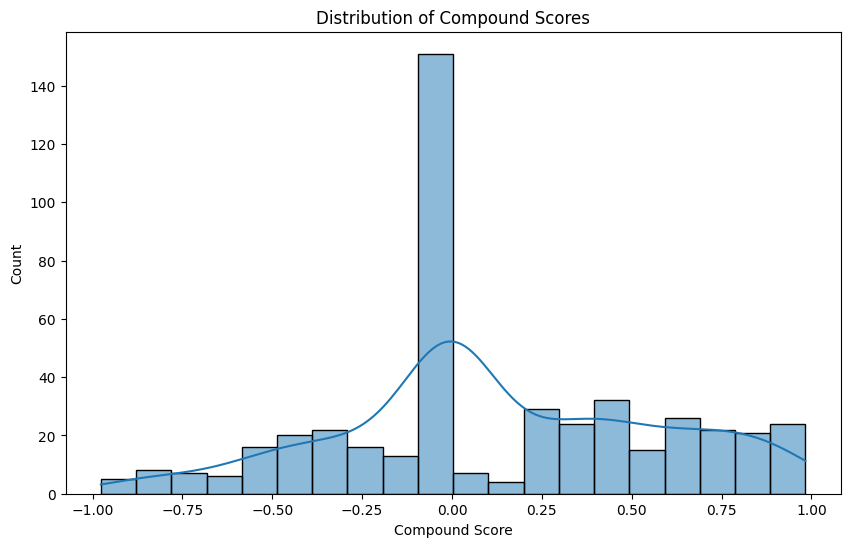

In [222]:
# Plot the distribution of compound scores
plt.figure(figsize=(10, 6))
sns.histplot(data=reddit_data_df, x='compound_score', bins=20, kde=True)
plt.title('Distribution of Compound Scores')
plt.xlabel('Compound Score')
plt.ylabel('Count')
plt.show()

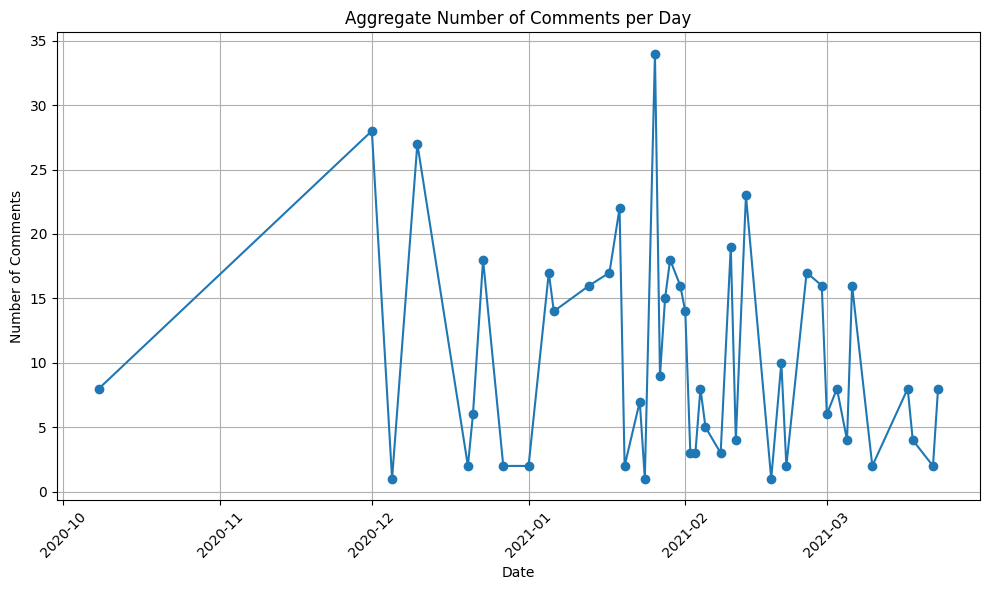

In [223]:
# Convert 'Comment Date Posted' column to datetime
reddit_data_df['Comment Date Posted'] = pd.to_datetime(reddit_data_df['Comment Date Posted'])

# Group by date and count the number of comments for each day
comments_per_day = reddit_data_df.groupby(reddit_data_df['Comment Date Posted'].dt.date).size()

# Plot the aggregate number of comments per day
plt.figure(figsize=(10, 6))
comments_per_day.plot(kind='line', marker='o')
plt.title('Aggregate Number of Comments per Day')
plt.xlabel('Date')
plt.ylabel('Number of Comments')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

It doesn't seem like number of comments will be helpful in predicting the stock price.

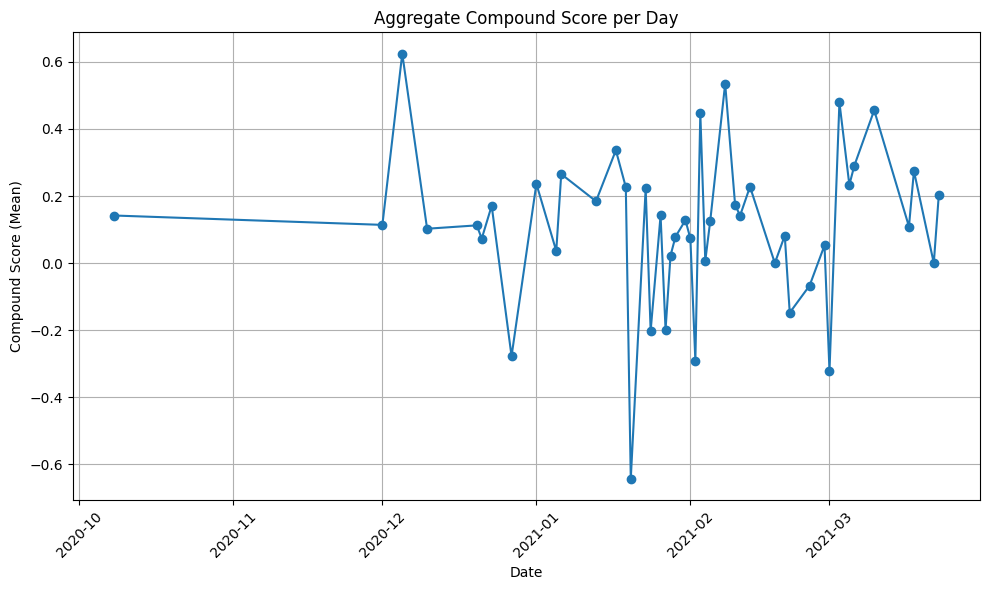

In [225]:
# Convert 'Comment Date Posted' column to datetime
reddit_data_df['Comment Date Posted'] = pd.to_datetime(reddit_data_df['Comment Date Posted'])

# Group by date and calculate the mean compound score for each day
compound_score_per_day = reddit_data_df.groupby(reddit_data_df['Comment Date Posted'].dt.date)['compound_score'].mean()

# Plot the aggregate compound score per day
plt.figure(figsize=(10, 6))
compound_score_per_day.plot(kind='line', marker='o')
plt.title('Aggregate Compound Score per Day')
plt.xlabel('Date')
plt.ylabel('Compound Score (Mean)')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()

/var/folders/vx/8dby43hn17xcd7y9qn2k2kjc0000gn/T/ipykernel_30688/2393853361.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



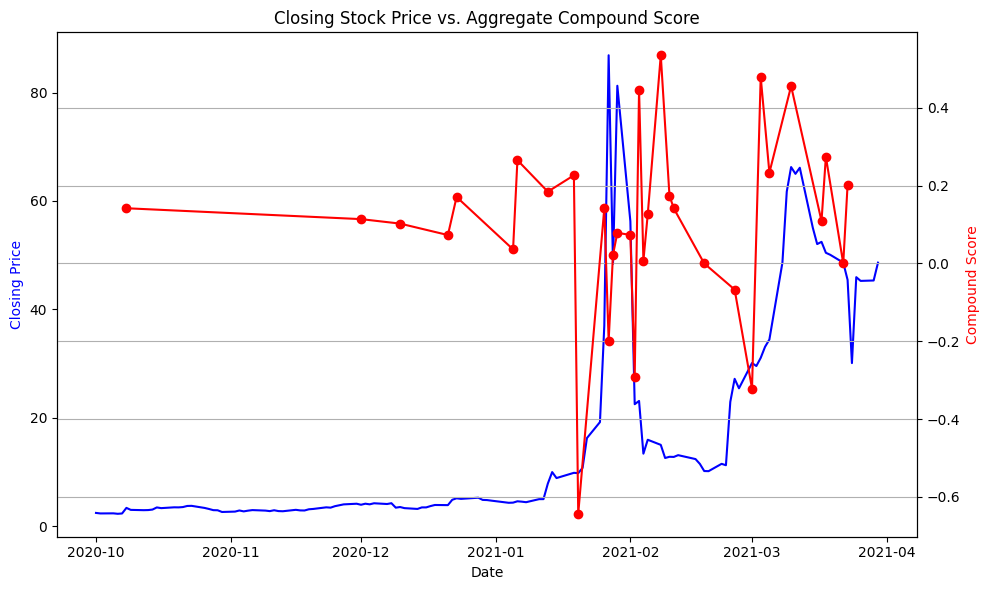

In [228]:
# Convert 'Comment Date Posted' column in reddit_data_df to datetime
reddit_data_df['Comment Date Posted'] = pd.to_datetime(reddit_data_df['Comment Date Posted']).dt.date

# Filter out dates in reddit_data_df that are not present in the index of gme_extended_df
valid_dates = gme_extended_df.index
reddit_data_df = reddit_data_df[reddit_data_df['Comment Date Posted'].isin(valid_dates)]

# Group by date and calculate the mean compound score for each day
compound_score_per_day = reddit_data_df.groupby('Comment Date Posted')['compound_score'].mean()

# Create a new figure and axis for plotting
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot the closing stock data on the primary y-axis
ax1.plot(gme_extended_df.index, gme_extended_df['Close'], label='Closing Stock Price', color='blue')
ax1.set_xlabel('Date')
ax1.set_ylabel('Closing Price', color='blue')

# Create a secondary y-axis for the compound score
ax2 = ax1.twinx()
ax2.plot(compound_score_per_day.index, compound_score_per_day, label='Compound Score (Mean)', color='red', marker='o')
ax2.set_ylabel('Compound Score', color='red')

# Title and legend
plt.title('Closing Stock Price vs. Aggregate Compound Score')
plt.grid(True)
plt.tight_layout()
plt.show()

#### iii. Model Fusion

Lets merge the sentiment analyses into the stock data

In [238]:
# Aggregate compound score and number of comments per day
compound_score_per_day = reddit_data_df.groupby('Comment Date Posted')['compound_score'].mean()
num_comments_per_day = reddit_data_df.groupby('Comment Date Posted').size().rename('num_comments')

# Merge with gme_extended_df
merged_df = gme_extended_df.merge(compound_score_per_day, how='left', left_on='Date', right_index=True)
merged_df = merged_df.merge(num_comments_per_day, how='left', left_on='Date', right_index=True)

# Fill missing values with 0
merged_df.fillna(0, inplace=True)

In [239]:
merged_df.head()

,Close,Volume,Close_Lag1,Close_Mean_7d,Close_Mean_30d,Volume_Mean_7d,Volume_Mean_30d,compound_score,num_comments
Date,,,,,,,,,
2020-10-01,2.4425,18216400,0.0000,0.0,0.0,0.0,0.0,0.0,0.0
2020-10-02,2.3475,17362000,2.4425,0.0,0.0,0.0,0.0,0.0,0.0
2020-10-05,2.3650,11220000,2.3475,0.0,0.0,0.0,0.0,0.0,0.0
2020-10-06,2.2825,18141600,2.3650,0.0,0.0,0.0,0.0,0.0,0.0
2020-10-07,2.3400,13234400,2.2825,0.0,0.0,0.0,0.0,0.0,0.0


In [240]:
# Reset index to move date from index to a column
merged_df.reset_index(inplace=True)

In [241]:
merged_df.head()

,Date,Close,Volume,Close_Lag1,Close_Mean_7d,Close_Mean_30d,Volume_Mean_7d,Volume_Mean_30d,compound_score,num_comments
0,2020-10-01,2.4425,18216400,0.0000,0.0,0.0,0.0,0.0,0.0,0.0
1,2020-10-02,2.3475,17362000,2.4425,0.0,0.0,0.0,0.0,0.0,0.0
2,2020-10-05,2.3650,11220000,2.3475,0.0,0.0,0.0,0.0,0.0,0.0
3,2020-10-06,2.2825,18141600,2.3650,0.0,0.0,0.0,0.0,0.0,0.0
4,2020-10-07,2.3400,13234400,2.2825,0.0,0.0,0.0,0.0,0.0,0.0


In [249]:
# Convert 'Date' column to datetime objects
merged_df['Date'] = pd.to_datetime(merged_df['Date']).dt.date

# Convert start_date and end_date to datetime.date objects
start_date = pd.Timestamp(start_date).date()
end_date = pd.Timestamp(end_date).date()

# Perform iterative training and prediction
predictions = []

filtered_df = merged_df[(merged_df['Date'] >= start_date) & (merged_df['Date'] <= end_date)]

for i in range(filtered_df.shape[0]):
    # Extract data up to current date for training
    train_data = merged_df[(merged_df['Date'] >= merged_df['Date'].iloc[29]) 
                                 & (merged_df['Date'] <= merged_df['Date'].iloc[41+i])]
    train = train_data.drop(columns=['Date'])
    # Drop the last row from X_train and store it in X_test
    X_test = train.iloc[-1]
    X_train = train.drop(train.index[-1])
    y_train = train_data['Close']
    y_train = y_train.drop(y_train.index[0])
    X_train, y_train = np.array(X_train), np.array(y_train)

    # Initialize the LSTM model
    model = Sequential([
        LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)),  # Use X_train shape as input shape
        Dropout(0.2),
        Dense(units=1)
    ])
    # Compile the model
    model.compile(optimizer='adam', loss='mean_squared_error')
    
    model.fit(X_train, y_train, epochs=1, batch_size=32, verbose=0)
    
    # Reshape X_test
    X_test = X_test.values.reshape(1, X_train.shape[1], 1)

    prediction = model.predict(X_test)
    predictions.append(prediction[0][0])


1/1 [==============================] - 2s 2s/step


(60,)


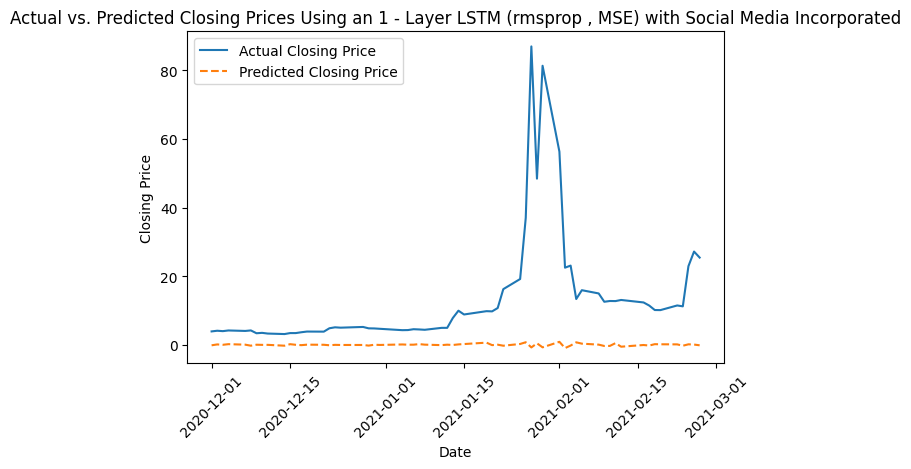

In [252]:
# Filter gme_extended_df based on start_date and end_date
filtered_df = merged_df[(merged_df['Date'] >= start_date) & (merged_df['Date'] <= end_date)]

# Extract dates and actual closing prices for plotting
dates = filtered_df['Date']
actual_closing_prices = filtered_df['Close']

print(actual_closing_prices.shape)
# Plot actual closing prices
plt.plot(dates, actual_closing_prices, label='Actual Closing Price')

# Plot predicted closing prices
plt.plot(dates, predictions, label='Predicted Closing Price', linestyle='--')

# Set labels and title
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.title('Actual vs. Predicted Closing Prices Using an 1 - Layer LSTM (rmsprop , MSE) with Social Media Incorporated')
plt.legend()

# Rotate x-axis labels for better visibility
plt.xticks(rotation=45)

# Show plot
plt.tight_layout()
plt.show()
